In [13]:
import numpy as np
import pandas as pd 
import os
from pandas import read_csv
from datetime import datetime
from pandas import read_csv
from matplotlib import pyplot
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from pandas import concat
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from numpy import nanmean
import statistics 
import math
import warnings 
warnings.filterwarnings('ignore')
warnings.filterwarnings('ignore', category=DeprecationWarning)
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score

In [14]:
os.chdir('H:\Mtech 3rd sem\capstone\DATA SETS GANS')

In [15]:
df = pd.read_csv("Pollution1.csv")

In [16]:
df.isnull().sum()

No          0
year        0
month       0
day         0
hour        0
pm2.5    2067
DEWP        0
TEMP        0
PRES        0
cbwd        0
Iws         0
Is          0
Ir          0
dtype: int64

In [17]:
df.head()


,No,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir
0,1,2010,1,1,0,NaN,-21,-11.0,1021.0,NW,1.79,0,0
1,2,2010,1,1,1,NaN,-21,-12.0,1020.0,NW,4.92,0,0
2,3,2010,1,1,2,NaN,-21,-11.0,1019.0,NW,6.71,0,0
3,4,2010,1,1,3,NaN,-21,-14.0,1019.0,NW,9.84,0,0
4,5,2010,1,1,4,NaN,-20,-12.0,1018.0,NW,12.97,0,0


In [18]:
def parse(x):
    return datetime.strptime(x, '%Y %m %d %H')
dataset = read_csv('pollution1.csv',  parse_dates = [['year', 'month', 'day', 'hour']], index_col=0, date_parser=parse)


In [19]:
dataset.head()

,No,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir
year_month_day_hour,,,,,,,,,
2010-01-01 00:00:00,1,NaN,-21,-11.0,1021.0,NW,1.79,0,0
2010-01-01 01:00:00,2,NaN,-21,-12.0,1020.0,NW,4.92,0,0
2010-01-01 02:00:00,3,NaN,-21,-11.0,1019.0,NW,6.71,0,0
2010-01-01 03:00:00,4,NaN,-21,-14.0,1019.0,NW,9.84,0,0
2010-01-01 04:00:00,5,NaN,-20,-12.0,1018.0,NW,12.97,0,0


In [20]:
final_data = dataset.iloc[:,1:]

In [21]:
final_data.head()

,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir
year_month_day_hour,,,,,,,,
2010-01-01 00:00:00,NaN,-21,-11.0,1021.0,NW,1.79,0,0
2010-01-01 01:00:00,NaN,-21,-12.0,1020.0,NW,4.92,0,0
2010-01-01 02:00:00,NaN,-21,-11.0,1019.0,NW,6.71,0,0
2010-01-01 03:00:00,NaN,-21,-14.0,1019.0,NW,9.84,0,0
2010-01-01 04:00:00,NaN,-20,-12.0,1018.0,NW,12.97,0,0


In [22]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
        # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together

    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [26]:
def model(data,y):
    data=data.dropna(axis=0, subset=[y])# y = "pm2.5"
    #Removing maximum Nan value columns 
    col=data.columns
    g=[]
    for j in range(data.shape[1]):
        if((data.iloc[:,j].isnull().sum())>=(data.shape[1]/2)):
            g.append(col[j])        
    data = data.drop(g,1)
    
    #mean and mode 
    
    col=data.columns
    
    for i in range(data.shape[1]):
        if((str(data.iloc[:,i].dtypes) == 'int64') or (str(data.iloc[:,i].dtypes) == 'float64')):
            t=nanmean(data[col[i]])
            data.loc[data[col[i]].isnull()==True,[col[i]]]=t
        else:
            t=statistics.mode(data[col[i]])
            data.loc[data[col[i]].isnull()==True,[col[i]]]=t
            
    
    data = pd.get_dummies(data)
    
    scaler=StandardScaler()
    data = data.select_dtypes(include=np.number)
    cols = data.columns
    data=scaler.fit_transform(data)
    data = pd.DataFrame(data,columns=cols) 
    
    reframed = series_to_supervised(data, 1, 1)
    reframed = reframed.iloc[:,:data.shape[1]+1]
    # split into train and test sets
    values = reframed.values
    n_train_hours = 365 * 24
    train = values[:n_train_hours, :]
    test = values[n_train_hours:, :]
    # split into input and outputs
    train_X, train_y = train[:, :-1], train[:, -1]
    test_X, test_y = test[:, :-1], test[:, -1]
    # reshape input to be 3D [samples, timesteps, features]
    train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
    test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
    #print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)
    
    
    # design network
    model = Sequential()
    model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
    model.add(Dense(1))
    model.compile(loss='mae', optimizer='adam')
    # fit network
    history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)
    # plot history
    pyplot.plot(history.history['loss'], label='train')
    pyplot.plot(history.history['val_loss'], label='test')
    pyplot.legend()
    pyplot.show()
    
    # make a prediction
    yhat = model.predict(test_X)
    test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
    # invert scaling for forecast
    inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
    inv_yhat = scaler.inverse_transform(inv_yhat)
    inv_yhat = inv_yhat[:,0]
    # invert scaling for actual
    test_y = test_y.reshape((len(test_y), 1))
    inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
    inv_y = scaler.inverse_transform(inv_y)
    inv_y = inv_y[:,0]
    # calculate RMSE
    rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
    r_square = r2_score(inv_y, inv_yhat)
    print('Test RMSE: %.3f' % rmse)
    print("R-square Value : ",r_square)

Train on 8760 samples, validate on 32996 samples
Epoch 1/50
 - 2s - loss: 0.5655 - val_loss: 0.4910
Epoch 2/50
 - 1s - loss: 0.3386 - val_loss: 0.2300
Epoch 3/50
 - 1s - loss: 0.1776 - val_loss: 0.1611
Epoch 4/50
 - 1s - loss: 0.1616 - val_loss: 0.1529
Epoch 5/50
 - 1s - loss: 0.1569 - val_loss: 0.1513
Epoch 6/50
 - 1s - loss: 0.1555 - val_loss: 0.1520
Epoch 7/50
 - 1s - loss: 0.1550 - val_loss: 0.1527
Epoch 8/50
 - 1s - loss: 0.1548 - val_loss: 0.1538
Epoch 9/50
 - 1s - loss: 0.1539 - val_loss: 0.1524
Epoch 10/50
 - 1s - loss: 0.1534 - val_loss: 0.1546
Epoch 11/50
 - 1s - loss: 0.1530 - val_loss: 0.1541
Epoch 12/50
 - 1s - loss: 0.1530 - val_loss: 0.1556
Epoch 13/50
 - 1s - loss: 0.1527 - val_loss: 0.1551
Epoch 14/50
 - 1s - loss: 0.1519 - val_loss: 0.1571
Epoch 15/50
 - 1s - loss: 0.1519 - val_loss: 0.1586
Epoch 16/50
 - 1s - loss: 0.1525 - val_loss: 0.1591
Epoch 17/50
 - 1s - loss: 0.1521 - val_loss: 0.1601
Epoch 18/50
 - 2s - loss: 0.1520 - val_loss: 0.1601
Epoch 19/50
 - 1s - loss

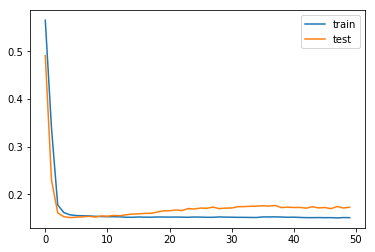

Test RMSE: 26.411
R-square Value :  0.9181774984158307


In [27]:
model(final_data,'pm2.5')